# Basic Reinforcement Learning
Purpose: To learn about RL from its most basic instantiation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import copy

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:6") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

In [2]:
device

device(type='cuda', index=6)

In [3]:
import gym

In [15]:
env = gym.make('LunarLander-v2')

In [4]:
env = gym.make('CartPole-v0')

# Agent

In [4]:
class Vector_env(gym.Wrapper):
    '''
     class Vector_env
     
     Acts as a wrapper for the OpenAI gym environments.
    '''
    def __init__(self, env, n=1):
        '''
         venv = Vector_env(env, n=1)
         
         Creates n copies of env.
        '''
        super().__init__(env)
        self.envs = []
        self.n_envs = n
        for k in range(n):
            env_r = copy.deepcopy(env)
            env_r.seed(np.random.randint(10000))
            self.envs.append(env_r)
    
    def reset(self):
        '''
         states = venv.reset()
         
         Resets all the environments, and returns an array with the
         reset states in each row.
        '''
        states = []
        for e in self.envs:
            state = e.reset()
            states.append(state)
        return np.array(states)
    
    def step(self, actions):
        '''
         S, R, done, info = venv.step(actions)
         
         Takes one step in each of the environments, and returns an array
         for each of the resulting outputs.
         
         Inputs:
           actions   an array of actions
           
         Outputs:
           S    array of states after the step
           R    array of rewards from the step
           done array of Boolean flags:
                  False means episode continues
                  True means episode is done
        '''
        S, R, dones = [], [], []
        for e,a in zip(self.envs, actions):
            next_s, r, done, inf = e.step(a)
            if done:
                S.append(e.reset())
            else:
                S.append(next_s)
            R.append(r)
            dones.append(done)
        return np.array(S), np.array(R), np.array(dones)
    
    def state(self):
        S = []
        for e in self.envs:
            S.append(e.state)
        return np.array(S)

In [18]:
class Agent():
    '''
     class Agent
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
    '''
    def __init__(self, envs):
        '''
         ag = Agent(envs)
         
         Instantiates an Agent object.
         
         Inputs:
           envs  a Vector_env object, containing the environments for the task
        '''
        self.envs = envs
        self.state_dim = self.envs.observation_space.shape[0]  #state_dim
        self.n_actions = self.envs.action_space.n  #n_actions
        #self.state = torch.zeros(self.state_dim)
        self._max_episode_steps = 100
        
        # Policy
        self.hidden = 100
        self.Pi_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.hidden, self.n_actions)).to(device)
        
        
        # Value function
        self.V_hidden = 80
        self.V_net = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.V_hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.V_hidden, 1)).to(device)
        
        # Eligibility-trace buffer for Pi_net
        self.Piz = []
        for p in self.Pi_net.parameters():
            self.Piz.append(torch.zeros_like(p))
            
        # Eligibility-trace buffer for V_net
        self.Vz = []
        for p in self.V_net.parameters():
            self.Vz.append(torch.zeros_like(p))
        
    def Pi(self, states=None):
        if states is None:
            S = torch.tensor(self.envs.state(), dtype=torch.float, device=device)
        else:
            S = torch.tensor(states, dtype=torch.float, device=device)
        return torch.distributions.Categorical(logits=self.Pi_net(S))
    
    def V(self, states=None):
        if states is None:
            S = torch.from_numpy(self.envs.state()).to(device)
        else:
            S = torch.tensor(states, dtype=torch.float).to(device)
        return self.V_net(S)
    
    
    def ChooseAction(self, state=None, eps=0.):
        '''
         A = ag.ChooseAction(state, eps=0.)
         
         Choose an action, given the state.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        if state is None:
            state = self.envs.state()
            
        batchsize = len(state)
        
        with torch.no_grad():
            Pa = self.Pi(state)
        A = Pa.sample().detach().cpu().numpy()
        
        # With prob eps, choose random action
        A_random = np.array(np.random.randint(0, high=self.n_actions, size=batchsize), dtype=np.float)
        r = np.random.rand(batchsize)
        ridx = r<eps
        A[ridx] = A_random[ridx]
        
        return A
  
    def Episode(self, gamma=1., eps=0.):
        '''
         traj = ag.Episode(gamma=1.)
         
         Runs one episode, and returns the trajectory. The environment is
         automatically reset at the beginning of the episode.
                 
         Inputs:
           gamma  reward discount
         
         Outputs:
           traj trajectory, as a list of lists of the form
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        S = self.envs.reset()
        traj = []
        bs = len(S)  # batchsize
        for k in range(self._max_episode_steps):
            action = self.ChooseAction(state=S, eps=eps)
            Snext, r, done = self.envs.step(action)
            traj.append(dict(action=action, S=S, Snext=Snext, r=r, G=np.zeros(bs), done=done))
            S = Snext
            if done.all():
                break
        # Use that trajectory (and rewards) to update the policy parameters
        # Process the return for all visited states
        #traj[-1][4] = np.zeros(bs)
        for k in range(len(traj)-2, -1, -1):
            traj[k]['G'] = traj[k]['r'] + (1.-traj[k]['done'])*gamma*traj[k+1]['G']
        return traj
    
    
    def orig_REINFORCE_baseline(self, gamma=1.0, alpha=0.0001, alpha_v=0.0001, eps=0.1):
        '''
         ag.REINFORCE_baseline(env, gamma=1.0, alpha=0.0001, alpha_v=0.0001)
         
         Performs an episode of the REINFORCE algorithm with baseline, following
         a reset of the environment. This method computes a model of the value
         function, in addition to a policy.
         
         Inputs:
           gamma  discount rate for rewards (default 1.0)
           alpha  step size for gradient ascent (the policy gradient)
           alpha_v step size for gradient ascent of the value function
           
         Output:
           traj   trajectory, a list of lists of the form:
                  [A, S, Snext, R, G, done, info]
                  A     action taken at state S
                  S     state
                  Snext state after taking action A
                  R     reward
                  G     future return (discounted)
                  done  flag to indicate episode is done
                  info  not sure ?
        '''
        v_mult = 1.
        
        # Perform an episode and record the trajectory
        traj = self.Episode(eps=eps(0))
        bs = len(traj[0]['action'])
                
        # Update policy parameters
        gamma_t = torch.tensor(gamma).to(device)
        Pa_loss = 0.
        V_loss = 0.
        
        Gmax = torch.zeros(bs, dtype=torch.float).to(device)
        
        for k,blah in enumerate(traj):
            A = torch.from_numpy(blah['action']).to(device)
            S = blah['S']
            G = torch.from_numpy(blah['G']).float().to(device)  # future return
            G.requires_grad = False
            dones = blah['done']
            
            Gmax = torch.max(Gmax, G)
            
            # Policy network
            Pa = self.Pi(S)  # returns a distribution object
            
            # Value network
            V = self.V(S)*v_mult
            
            # Error
            with torch.no_grad():
                err = G - V
            
            # Recall that d(log(Pi)) = dPi / Pi
            logPa_x_err = Pa.log_prob(A) * err * gamma_t
            
            Pa_loss = Pa_loss + torch.mean(logPa_x_err)
            V_loss = V_loss + torch.mean( (G-V)**2 ) * gamma_t
            
            gamma_t = gamma_t*gamma
        
        # Backproject gradient
        self.Pi_net.zero_grad()
        self.V_net.zero_grad()
        Pa_loss.backward()
        V_loss.backward()
        with torch.no_grad():
            for p in self.Pi_net.parameters():
                p += alpha * p.grad
            for p in self.V_net.parameters():
                p -= alpha_v * p.grad
            
        #return traj
        #return torch.mean( torch.max(G, dim=0)[0] ).cpu().item()
        return torch.mean(Gmax).cpu().item()

    def ComputeReturns(self, R, dones, gamma=1.):
        G = np.zeros_like(R)
        G[-1] = R[-1]
        for k in range(len(R)-2, -1, -1):
            G[k] = R[k] + (1.-dones[k])*G[k+1]
        return G

    def Simulate(self, trials=1, eps=0.):
        time.sleep(1)
        avg_k = 0.
        for trial in range(trials):
            observation = self.envs.envs[0].reset()
            for k in range(self._max_episode_steps):
                self.envs.envs[0].render()
                action = self.ChooseAction(state=[observation], eps=eps)

                observation, reward, done, info = self.envs.envs[0].step(action[0])

                if done:
                    print('Done after '+str(k))
                    avg_k += k
                    break
        print('Average reward: '+str(avg_k/trials))
        time.sleep(1)
        self.envs.envs[0].close()
        
        
    def REINFORCE_baseline(self, T=200, gamma=1.0, alpha=0.0001, alpha_v=0.0001, eps=0.1):
        
        # Run and record a batch of rollouts
        states = np.empty((T, self.envs.n_envs, self.state_dim))
        actions = np.empty((T, self.envs.n_envs))
        rewards = np.empty((T, self.envs.n_envs))
        dones = np.empty((T, self.envs.n_envs))
        S = self.envs.reset()
        for t in range(T):
            A = self.ChooseAction(state=S, eps=eps(t))
            Snext, r, done = self.envs.step(A)
            states[t] = S
            actions[t] = A
            rewards[t] = r
            dones[t] = done
            S = Snext
            
        A = torch.from_numpy(A).to(device)
        
        # Calculate returns
        G = self.ComputeReturns(rewards, dones, gamma=gamma)
        G = torch.from_numpy(G).to(device)
        G.requires_grad = False
        
        # Run the policy network and value network on the rollout
        Pa = self.Pi(states)
        V = self.V(states).squeeze()

        # Calculate error
        with torch.no_grad():
            delta = G - V

        # Policy loss
        logPa_x_err = torch.mean( Pa.log_prob(A) * delta )
        
        # Critic loss
        loss_V = torch.mean((G-V)**2)
        
        
        # Backproject gradient
        self.Pi_net.zero_grad()
        self.V_net.zero_grad()
        logPa_x_err.backward()
        loss_V.backward()
        
        # Gradient step
        with torch.no_grad():
            for p in self.Pi_net.parameters():
                p += alpha * p.grad
            for p in self.V_net.parameters():
                p -= alpha_v * p.grad

        return torch.mean( torch.max(G, dim=0)[0] ).cpu().item()

### Cart-Pole

In [49]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
S = env.reset()
envs = Vector_env(env, n=32)
ag_r = Agent(envs)
ag_r._max_episode_steps = 200

In [473]:
Gavg = ag_r.REINFORCE_baseline(T=200, alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 1.))

In [475]:
Gavg

46.0

In [20]:
Gavg = ag_r.orig_REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 1.))

In [21]:
Gavg

44.0

In [235]:
T = 100; eps=0.
states = np.empty((T, ag_r.envs.n_envs, ag_r.state_dim))
actions = np.empty((T, ag_r.envs.n_envs))
rewards = np.empty((T, ag_r.envs.n_envs))
dones = np.empty((T, ag_r.envs.n_envs))
for t in range(T):
    A = ag_r.ChooseAction(state=S, eps=eps)
    Snext, r, done = ag_r.envs.step(A)
    states[t] = S
    actions[t] = A
    rewards[t] = r
    dones[t] = done
    S = Snext
#print(dones)

In [50]:
score = []
counter = 0

In [51]:
interval = 50

In [ ]:
mysum = 0.
for i_episode in range(500):
    Gavg = ag_r.orig_REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 0.1))
    #traj = ag_r.REINFORCE(alpha=0.0001, eps=0.)
    counter += 1
    mysum += Gavg
    if counter%interval==0:
        print(f'{counter}: {mysum/interval}')
        score.append(mysum/interval)
        mysum = 0.

50: 50.466875


In [39]:
mysum = 0.
for i_episode in range(200):
    mean_G = ag_r.REINFORCE_baseline(T=200, alpha=0.0001, alpha_v=0.0001, eps=(lambda x: 0.))
    #traj = ag_r.REINFORCE(alpha=0.0001, eps=0.)
    counter += 1
    mysum += mean_G
    if counter%interval==0:
        print(f'{counter}: {mysum/interval}')
        score.append(mysum/interval)
        mysum = 0.

810: 117.95
820: 116.46875
830: 117.6875
840: 115.165625
850: 117.953125
860: 120.20625
870: 118.246875
880: 118.703125
890: 120.378125
900: 120.5
910: 118.428125
920: 116.6375
930: 118.1125
940: 121.059375
950: 120.740625
960: 119.328125
970: 116.209375
980: 118.828125
990: 117.240625
1000: 120.93125


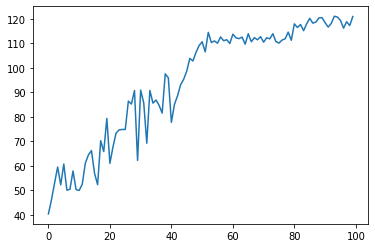

In [40]:
plt.plot(score);

In [27]:
ag_r.Simulate(3, eps=0.1)

NoSuchDisplayException: Cannot connect to "None"

In [32]:
ag_r.envs.envs[0].close()

## REINFORCE with Baseline

In [61]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_rb = Agent(env)
ag_rb.env._max_episode_steps = 500

In [62]:
score2 = []
counter = 0
mysum = 0
interval = 50

In [76]:
for i_episode in range(200):
    traj = traj = ag_rb.REINFORCE_baseline(alpha=0.0001, alpha_v=0.0001)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score2.append(mysum/interval)
        mysum = 0

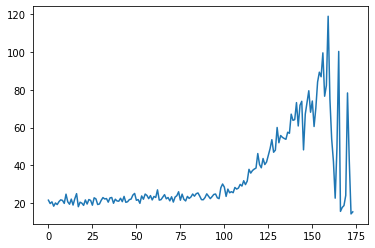

In [77]:
plt.plot(score2);

In [75]:
S = ag_rb.env.reset()
print(S)
ag_rb.V(torch.tensor(S, dtype=torch.float))

[-0.0245504   0.0344018  -0.00279386  0.02541287]


tensor([1.8533], grad_fn=<AddBackward0>)

In [63]:
ag_rb.V(torch.tensor([0, 0, 0, 0], dtype=torch.float))

tensor([17.9258], grad_fn=<AddBackward0>)